In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

In [3]:
import pandas as pd
import numpy as np

#Подготовка Данных

In [115]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_test.csv')

In [116]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25062 entries, 0 to 25061
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              25062 non-null  object 
 1   Category          25062 non-null  object 
 2   Brand             25061 non-null  object 
 3   Seller            25031 non-null  object 
 4   Color             127 non-null    object 
 5   Comments          25062 non-null  float64
 6   Final price       25062 non-null  float64
 7   Max price         25062 non-null  float64
 8   Min price         25062 non-null  float64
 9   Average price     19264 non-null  float64
 10  Sales             25062 non-null  float64
 11  Days in stock     25062 non-null  float64
 12  Days with sales   25062 non-null  int64  
 13  Rating            25062 non-null  object 
 14  Basic Sale        25062 non-null  float64
 15  Basic Sale Price  25062 non-null  float64
 16  Base price        25062 non-null  float6

Добавим среднюю цену среди категории

In [117]:
avg_price_per_category = []
for cat in np.unique(train_data['Category'].values):
    # print(cat)
    avg_price_per_category.append(train_data[train_data['Category'] == cat]['Average price'].mean())
    cat_mean_price = train_data[train_data['Category'] == cat]['Average price'].mean()
    train_data.loc[train_data['Category'] == cat, 'Avg_price_per_category'] = cat_mean_price
# print(avg_price_per_category)
# train_data.head()

avg_price_per_category = []
for cat in np.unique(test_data['Category'].values):
    # print(cat)
    avg_price_per_category.append(test_data[test_data['Category'] == cat]['Average price'].mean())
    cat_mean_price = test_data[test_data['Category'] == cat]['Average price'].mean()
    test_data.loc[test_data['Category'] == cat, 'Avg_price_per_category'] = cat_mean_price

Добавим фичу, если средняя цена продажи не выше чем средняя цена по сегменту - 1, иначе 0




In [118]:
train_data['avg_price_not_more_than_evg_cat'] = np.where((train_data['Avg_price_per_category'] >= train_data['Average price']), 1, 0)
train_data['avg_price_not_more_than_evg_cat'] = train_data['avg_price_not_more_than_evg_cat'].astype('object')

test_data['avg_price_not_more_than_evg_cat'] = np.where((test_data['Avg_price_per_category'] >= test_data['Average price']), 1, 0)
test_data['avg_price_not_more_than_evg_cat'] = test_data['avg_price_not_more_than_evg_cat'].astype('object')

ratings = train_data['Rating'].values
num_ratings = [int(rating.split(',')[0]) for rating in ratings]
train_data['Rating'] = num_ratings

ratings = test_data['Rating'].values
num_ratings = [int(rating.split(',')[0]) for rating in ratings]
test_data['Rating'] = num_ratings

In [119]:
# print(f"mean: {train_data['Comments'][:len(train_data['Comments'].values)].mean()}")
print(f"mean: {train_data.sort_values(by='Comments').loc[:len(train_data.sort_values(by='Comments')['Comments'].values)-1, 'Comments'].mean()}")

# train_data.sort_values(by='Comments').loc[:len(train_data.sort_values(by='Comments')['Comments'].values)-1, 'Comments'].value_counts()

mean: 4.590824942430126


In [120]:
train_data['comments_more_than_avg'] = (train_data['Comments'] > 5).astype('object')
# pd.crosstab(train_data['comments_more_than_avg'], train_data['Sales'], margins=True)
test_data['comments_more_than_avg'] = (test_data['Comments'] > 5).astype('object')

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

**посмотрим на распределение цен**
Видим, что у нас есть выборосы
разделим датасет на 2 части

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


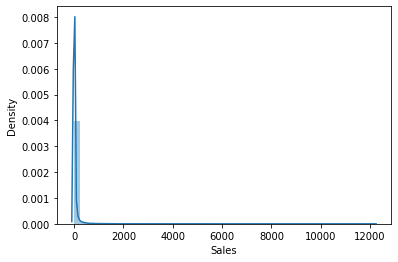

In [38]:
sns.distplot(train_data.Sales)

Разделим датасет на 2 части: с продажами менее 100 единиц и более 100 единиц включительно

In [123]:
train_data_less = train_data[train_data['Sales'] < 100.0]
_train_data = train_data[(train_data['Sales'] >= 100.0)]
train_data_middle = _train_data[_train_data['Sales'] < 1000.0]
train_data_more = _train_data[_train_data['Sales'] >= 1000.0]

# train_data['max_sales'] = np.where((train_data['Sales'] > 100), 1, 0)
# train_data['max_sales'] = (train_data['max_sales']).astype('object')

# train_data['max_sales'].value_counts()

# sales = train_data['Sales'].values
# for i in range(len(sales)):
#     if sales[i] > 100:
#         sales[i] = 100

# train_data['Sales'] = sales

**посмотрим на распределение продаж, у которых менее 100**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


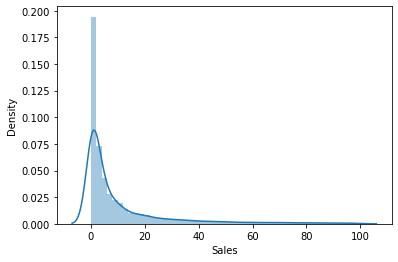

In [124]:
sns.distplot(train_data_less.Sales)

In [41]:
train_data_more.sort_values(by='Sales', ascending=False).head()

,Name,Category,Brand,Seller,Color,Comments,Final price,Max price,Min price,Average price,...,Days in stock,Days with sales,Rating,Basic Sale,Basic Sale Price,Base price,full_category,Avg_price_per_category,avg_price_not_more_than_evg_cat,comments_more_than_avg
18146,Весы кухонные электронные / для питания / прод...,/Техника для кухни/Кухонные весы,Eco Ness,Козлов Алексей Николаевич ИП,NaN,3921.0,378.0,378.0,378.0,378.000000,...,31.0,31,5,55.0,504.0,1120.0,Бытовая техника/Техника для кухни/Кухонные весы,896.083999,1,True
17252,Пульсоксиметр,/Красота и здоровье/Медицинские приборы/Пульсо...,FINGER O2XYGEN,Ганин Сергей Владимирович,NaN,1799.0,965.0,965.0,965.0,965.000000,...,30.0,31,4,80.0,965.0,4828.0,Бытовая техника/Красота и здоровье/Медицинские...,1018.662539,1,True
18690,Контактный гриль Tefal Inicio GC241D38,/Техника для кухни/Приготовление блюд/Грили эл...,Tefal,ВАЙЛДБЕРРИЗ ООО,NaN,1167.0,3995.0,3995.0,3595.0,3730.237886,...,28.0,30,5,50.0,3995.0,7990.0,Бытовая техника/Техника для кухни/Приготовлени...,5666.356098,1,True
12537,Электрическая зубная щётка ORAL-B Vitality D10...,/Красота и здоровье/Зубные щетки и ирригаторы/...,Oral-B,ВАЙЛДБЕРРИЗ ООО,NaN,759.0,2153.0,2153.0,1722.0,1796.360077,...,16.0,27,5,0.0,2153.0,2153.0,Бытовая техника/Красота и здоровье/Зубные щетк...,2665.404254,1,True
19743,Машинка против катышек MW-3101,/Техника для дома/Уход за вещами,MAXWELL,ГОЛДЕР-ЭЛЕКТРОНИКС ООО,NaN,1750.0,389.0,528.0,340.0,452.976307,...,20.0,24,5,19.0,486.0,601.0,Бытовая техника/Техника для дома/Уход за вещами,783.445899,1,True


**Теперь посмотрим на распределение продаж тех, у которых более 100**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


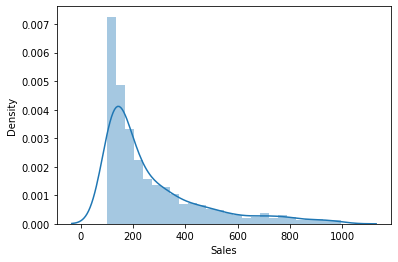

In [125]:
sns.distplot(train_data_middle.Sales)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


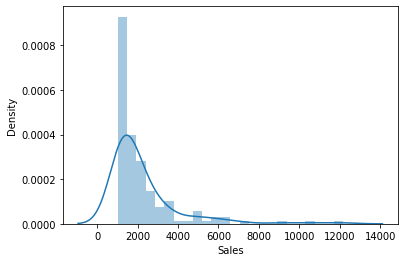

In [126]:
sns.distplot(train_data_more.Sales)

In [43]:
# train_data['max_sales'] = np.where((train_data['Sales'] > 6000), 1, 0)
# train_data['max_sales'] = (train_data['max_sales']).astype('object')

# train_data['max_sales'].value_counts()

0    25055
1        7
Name: max_sales, dtype: int64

In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25062 entries, 0 to 25061
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Name                             25062 non-null  object 
 1   Category                         25062 non-null  object 
 2   Brand                            25061 non-null  object 
 3   Seller                           25031 non-null  object 
 4   Color                            127 non-null    object 
 5   Comments                         25062 non-null  float64
 6   Final price                      25062 non-null  float64
 7   Max price                        25062 non-null  float64
 8   Min price                        25062 non-null  float64
 9   Average price                    19264 non-null  float64
 10  Sales                            25062 non-null  float64
 11  Days in stock                    25062 non-null  float64
 12  Days with sales   

In [52]:
def deleteId(ds):
    return ds.drop(columns='Id')

def deleteNaN(train_ds, test_ds, critval):
    fullsize = train_ds.shape[0]
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    for feature in new_train.columns:
        nulls = new_train[feature].isnull().sum()
        percent = nulls / fullsize
        # если доля пустых значений превышает critval - столбец не информативен,
        # можно его выбросить
        if (percent > critval):
            new_train = new_train.drop(columns=feature)
            new_test = new_test.drop(columns=feature)
    return new_train, new_test

def convertToNumeric(train_ds, test_ds):
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    LE = LabelEncoder()
    for feature in new_train.columns:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = LE.fit_transform(new_train[feature])
            new_test[feature] = LE.fit_transform(new_test[feature])
    return new_train, new_test

In [167]:
train = train_data.drop_duplicates()

# train = train.drop(columns='Id')
train = train.drop(columns='Color')
train = train.drop(columns='Base price')
train = train.drop(columns='Basic Sale Price')

test = test_data.drop(columns='Id')
test = test.drop(columns='Color')
test = test.drop(columns='Base price')
test = test.drop(columns='Basic Sale Price')

train, test = deleteNaN(train, test, critval=0.8)
train, test = convertToNumeric(train, test)

train_y = train['Sales'].values
train_X = train.drop(columns='Sales').values
val_test = test.values

train_x, test_x, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=7)  # random_state=98987)

#Избавимся от NaN значений


In [168]:
strategies = ['mean', 'median', 'most_frequent']
imputer = SimpleImputer(strategy=strategies[2])
trainX = imputer.fit_transform(train_x)
testX = imputer.fit_transform(test_x)
val_test_x = imputer.fit_transform(val_test)

In [169]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
val_test_x = scaler.transform(val_test_x)

In [170]:
trainX.shape

(20529, 17)

In [171]:
val_test.shape

(10741, 17)

#Метрика **SMAPE**

In [58]:
def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

In [59]:
def check_error(preds, gt):
    print('SMAPE Error:', smape(np.round(preds), gt))
    # print('RMSE Error:', mean_squared_error(np.round((np.abs(preds))), gt, squared=False))

#Random Forest

In [ ]:
parameters = {
    'criterion':(['absolute_error']), 
    'max_depth':  [100, 500, 100],
    'n_estimators': [40, 50, 60, 55],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': range(10, 71, 20)}

model = RandomForestRegressor()
rf_gs_model = GridSearchCV(model, parameters)
rf_gs_model.fit(trainX[:300], train_y[:300])
print(f"Best parameters: {rf_gs_model.best_params_}")

In [212]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 1000,  # 300
    'n_estimators': 50, # 70
    'min_samples_leaf': 4, # 3
    'min_samples_split': 3 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
random_forest = RandomForestRegressor(**last_rf_best_params) 
random_forest.fit(trainX, train_y)
check_error(random_forest.predict(testX), test_y)

SMAPE Error: 17.694568654021733


In [177]:
check_error(random_forest.predict(testX), test_y)
print(random_forest.predict(testX))

SMAPE Error: 16.74329116765592
[4.38571429 1.40714286 8.38571429 ... 0.         6.26428571 1.05714286]


#XGBoost

In [ ]:
parameters = {
    "learning_rate": [0.1, 0.01, 0.075, 0.015],
    "max_depth": [3, 4, 10, 100],
    "min_child_weight": [3, 5, 7, 10],
    # "n_estimators": range(10, 51, 10),
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.],
    "gamma": [0.5, 0.7, 0.3, 1.],
    "reg_lambda": [0.6, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.]
}

model = XGBRegressor(objective='reg:squarederror')
xgb_gs_model = GridSearchCV(model, parameters)
xgb_gs_model.fit(trainX, train_y)
print(f"Best parameters: {xgb_gs_model.best_params_}")

# gridcv_xgb = xgb_gs_model.best_estimator_
# check_error(np.round(gridcv_xgb.predict(testX)), test_y)

In [184]:
last_xgb_best_params = {
    "learning_rate": 0.15,
    "max_depth": 3,
    "min_child_weight": 4,
    "n_estimators": 50, 
    "subsample": 0.9,
    "booster": 'gbtree',
    "reg_lambda": 1.,
    "gamma": 0.5,
    'colsample_bytree': 0.9
}
xgb_reg = XGBRegressor(**last_xgb_best_params) 
# xgb_reg = XGBRegressor(**xgb_gs_model.best_params_)
xgb_reg.fit(trainX, train_y)
check_error(np.round(xgb_reg.predict(testX)), test_y)


[11:49:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE Error: 40.217140768618584


#Модель комбинированная

**подготовка данных**

In [129]:
train = train_data.drop_duplicates()

# train = train.drop(columns='Id')
train = train.drop(columns='Color')
train = train.drop(columns='Base price')
train = train.drop(columns='Basic Sale Price')

test = test_data.drop(columns='Id')
test = test.drop(columns='Color')
test = test.drop(columns='Base price')
test = test.drop(columns='Basic Sale Price')

train, test = deleteNaN(train, test, critval=0.8)
train, test = convertToNumeric(train, test)  # а в какой тип даннных превращатся категориальные? 

train_data_less = train[train_data['Sales'] < 100.0]
_train_data = train[(train_data['Sales'] >= 100.0)]
train_data_middle = _train_data[_train_data['Sales'] < 1000.0]
train_data_more = _train_data[_train_data['Sales'] >= 1000.0]

train0_y = train_data_less['Sales'].values
train0_X = train_data_less.drop(columns='Sales').values
train1_y = train_data_middle['Sales'].values
train1_X = train_data_middle.drop(columns='Sales').values
train2_y = train_data_more['Sales'].values
train2_X = train_data_more.drop(columns='Sales').values
train_y = train['Sales'].values
train_X = train.drop(columns='Sales').values
val_test = test.values

train_x, test_x, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=7)  # random_state=98987)
train0_x, test0_x, train0_y, test0_y = train_test_split(train0_X, train0_y, test_size=0.1, random_state=7)
train1_x, test1_x, train1_y, test1_y = train_test_split(train1_X, train1_y, test_size=0.1, random_state=7)
train2_x, test2_x, train2_y, test2_y = train_test_split(train2_X, train2_y, test_size=0.1, random_state=7)

<ipython-input-129-2abf1adc6062>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data_less = train[train_data['Sales'] < 100.0]
<ipython-input-129-2abf1adc6062>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _train_data = train[(train_data['Sales'] >= 100.0)]


In [130]:
strategies = ['mean', 'median', 'most_frequent']
imputer = SimpleImputer(strategy=strategies[2])
train0X = imputer.fit_transform(train0_x)
test0X = imputer.fit_transform(test0_x)
imputer = SimpleImputer(strategy=strategies[2])
train1X = imputer.fit_transform(train1_x)
test1X = imputer.fit_transform(test1_x)
imputer = SimpleImputer(strategy=strategies[2])
train2X = imputer.fit_transform(train2_x)
test2X = imputer.fit_transform(test2_x)
imputer = SimpleImputer(strategy=strategies[2])
trainX = imputer.fit_transform(train_x)
testX = imputer.fit_transform(test_x)
val_test_x = imputer.fit_transform(val_test)

scaler = StandardScaler()
train0X = scaler.fit_transform(train0X)
test0X = scaler.transform(test0X)
scaler = StandardScaler()
train1X = scaler.fit_transform(train1X)
test1X = scaler.transform(test1X)
scaler = StandardScaler()
train2X = scaler.fit_transform(train2X)
test2X = scaler.transform(test2X)
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)
val_test_x = scaler.transform(val_test_x)

**меньше 100**

In [61]:
parameters = {
    'criterion':(['absolute_error']), 
    'max_depth':  [70, 100, 300, 1000],
    'n_estimators': [50, 60, 70, 100],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 10, 50]}

model = RandomForestRegressor()
rf_gs_model = GridSearchCV(model, parameters)
rf_gs_model.fit(train0X[:300], train0_y[:300])
print(f"Best parameters: {rf_gs_model.best_params_}")

Best parameters: {'criterion': 'absolute_error', 'max_depth': 300, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 70}


In [62]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 300,  # 300
    'n_estimators': 70, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 3 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf0 = RandomForestRegressor(**last_rf_best_params) 
rf0.fit(train0X, train0_y)
check_error(rf0.predict(test0X), test0_y)

SMAPE Error: 17.206817495943717


**от 100 до 1000**

In [135]:
train1X.shape

(1424, 17)

In [208]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 1000,  # 300
    'n_estimators': 30, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 2 # 1
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf1 = RandomForestRegressor(**last_rf_best_params) 
rf1.fit(train1X, train1_y)
check_error(rf1.predict(test1X), test1_y)

SMAPE Error: 34.76378231285994


In [210]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 700,  # 300
    'n_estimators': 35, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 2 # 1
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf11 = RandomForestRegressor(**last_rf_best_params) 
rf11.fit(train1X, train1_y)
check_error(rf1.predict(test1X), test1_y)

SMAPE Error: 34.76378231285994


**более 1000**

In [63]:
parameters = {
    'criterion':(['absolute_error']), 
    'max_depth':  [70, 100, 300, 1000],
    'n_estimators': [50, 60, 70, 100],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 10, 50]}

model = RandomForestRegressor()
rf_gs_model = GridSearchCV(model, parameters)
rf_gs_model.fit(train2X[:300], train2_y[:300])
print(f"Best parameters: {rf_gs_model.best_params_}")

Best parameters: {'criterion': 'absolute_error', 'max_depth': 300, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 70}


In [146]:
train2X.shape

(131, 17)

In [155]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 3,  # 300
    'n_estimators': 10, # 70
    'min_samples_leaf': 3, # 3
    'min_samples_split': 2 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
rf2 = RandomForestRegressor(**last_rf_best_params) 
rf2.fit(train2X, train2_y)
check_error(rf2.predict(test2X), test2_y)

SMAPE Error: 49.70169679960313


In [203]:
last_xgb_best_params = {
    "learning_rate": 0.15,
    "max_depth": 5,
    "min_child_weight": 10,
    "n_estimators": 25, 
    "subsample": 0.9,
    "booster": 'gbtree',
    "reg_lambda": 1.,
    "gamma": 0.1,
    'colsample_bytree': 1.
}
xgb_reg = XGBRegressor(**last_xgb_best_params) 
# xgb_reg = XGBRegressor(**xgb_gs_model.best_params_)
xgb_reg.fit(train2X, train2_y)
check_error(np.round(xgb_reg.predict(test2X)), test2_y)

[11:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE Error: 39.461455265582885


**теперь нужен мета алгоритм**

In [211]:
trainX.shape

(22086, 17)

In [212]:
predictions0 = np.round(rf0.predict(trainX))
predictions1 = np.round(rf11.predict(trainX))
predictions2 = np.round(xgb_reg.predict(trainX))
# predictions0.shape
train_samples = trainX
train_samples = np.insert(train_samples, 0, predictions0, axis=1)
train_samples = np.insert(train_samples, 0, predictions1, axis=1)
train_samples = np.insert(train_samples, 0, predictions2, axis=1)
train_samples.shape

(22086, 20)

In [213]:
predictions0 = np.round(rf0.predict(testX))
predictions1 = np.round(rf11.predict(testX))
predictions2 = np.round(xgb_reg.predict(testX))
# predictions0.shape
test_samples = testX
test_samples = np.insert(test_samples, 0, predictions0, axis=1)
test_samples = np.insert(test_samples, 0, predictions1, axis=1)
test_samples = np.insert(test_samples, 0, predictions2, axis=1)
test_samples.shape

(2454, 20)

In [214]:
scaler = StandardScaler()
train_samples = scaler.fit_transform(train_samples)
test_samples = scaler.transform(test_samples)

In [215]:
last_rf_best_params = {
    'criterion': 'absolute_error', 
    'max_depth': 70,  # 300
    'n_estimators': 70, # 70
    'min_samples_leaf': 5, # 3
    'min_samples_split': 3 # 50
}

# random_forest = RandomForestRegressor(**rf_gs_model.best_params_)
random_forest = RandomForestRegressor(**last_rf_best_params) 
random_forest.fit(train_samples, train_y)
check_error(random_forest.predict(test_samples), test_y)

SMAPE Error: 21.08810717825116


#Соревы

In [92]:
submission_path = '/content/drive/MyDrive/Colab Notebooks/ML 4 course/nsu_sample_solution.csv'
submission = pd.read_csv(submission_path)

In [216]:
predictions0 = np.round(rf0.predict(val_test_x))
predictions1 = np.round(rf11.predict(val_test_x))
predictions2 = np.round(xgb_reg.predict(val_test_x))
# predictions0.shape
val_samples = val_test_x
val_samples = np.insert(val_samples, 0, predictions0, axis=1)
val_samples = np.insert(val_samples, 0, predictions1, axis=1)
val_samples = np.insert(val_samples, 0, predictions2, axis=1)
val_samples.shape
scaler = StandardScaler()
val_samples = scaler.fit_transform(val_samples)

In [217]:
predictions = np.round(random_forest.predict(val_samples))
submission['Expected'] = predictions
submission
submission.to_csv('submission_rf.csv', index=False)

In [86]:
predictions = np.round(xgb_reg.predict(val_test_x))
submission['Expected'] = predictions
submission
submission.to_csv('submission_xgboost.csv', index=False)